<a href="https://colab.research.google.com/github/ananya-ayasi/DL-for-Audio/blob/main/fine_tune_SBU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/niconielsen32/NeuralNetworks/blob/main/transferLearning.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import csv
import os
import librosa
import glob
import keras
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas
import tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q python_speech_features
from python_speech_features import mfcc, logfbank, delta

In [4]:
no_mfcc=13
no_mtf=7
no_features=3*no_mfcc+no_mtf
N_classes=8 

In [5]:
# Initial Parameters
utterance_length = 4600   # maximum-found manually

In [6]:
folders=os.listdir(path='/content/drive/MyDrive/NEW_MTF')

In [7]:
X=np.zeros((384,46,utterance_length))
XP1=np.zeros((utterance_length,7))

In [8]:
y=np.zeros((384))
train=np.zeros((384))

In [9]:
file_no=0

In [10]:
for i in range(len(folders)):

  files=glob.glob('/content/drive/MyDrive/NEW_MTF/'+folders[i]+'/*')
  res = folders[i].split('_')
  label=res[0].split('m')[1]
  f2='Niram'+label
  label=int(label)-1
  
  if res[1]=='train':
    train1=1
    f1='Niram_train/'
    f3='_train_new/'
  else:
    train1=0
    f1='Niram_test/'
    f3='_test_new/'

  for ff in files:

    print('filename-------',ff)
    f4=ff.split('/')[6]
    audio='/content/drive/MyDrive/'+f1+f2+f3+f4+'.wav'
    print('audio name---',audio)
    print('label--', label,train1)

    df = pandas.read_csv(ff,header=None)
    XP=df.iloc[:,0:no_mtf].values
    XP1[:XP.shape[0],:]=XP
    
    audio_signal,sr =librosa.load(audio,sr=None)

    mfcc_features = librosa.feature.mfcc(y=audio_signal,sr=sr,n_mfcc=no_mfcc,hop_length=int(0.010*sr), n_fft=int(0.030*sr))
    d1_mfcc_feat = delta(mfcc_features, 2)
    d2_mfcc_feat = delta(d1_mfcc_feat, 2)
    
    if mfcc_features.shape[1] > utterance_length:
        mfcc_features1 = mfcc_features[:, 0:utterance_length]
        d1_mfcc_feat1=d1_mfcc_feat[:, 0:utterance_length]
        d2_mfcc_feat1=d2_mfcc_feat[:, 0:utterance_length]
        
    else:
        mfcc_features1 = np.pad(mfcc_features, ((0, 0), (0, utterance_length - mfcc_features.shape[1])),
                               mode='constant', constant_values=0)
        d1_mfcc_feat1 =np.pad(d1_mfcc_feat , ((0, 0), (0, utterance_length - mfcc_features.shape[1])),
                               mode='constant', constant_values=0)
        d2_mfcc_feat1 =np.pad(d2_mfcc_feat , ((0, 0), (0, utterance_length - mfcc_features.shape[1])),
                               mode='constant', constant_values=0)
        
    if mfcc_features1.shape[1] > XP.shape[0]:
         XP1[XP.shape[0]:mfcc_features.shape[1],:]=np.zeros(((mfcc_features.shape[1]-XP.shape[0]),7))

    combined=np.zeros((46,utterance_length))
    combined[:13,] = mfcc_features1
    combined[13:26,]=d1_mfcc_feat1
    combined[26:39,]=d2_mfcc_feat1
    combined[39:46,]=XP1.T
    y[file_no]=int(label)
    train[file_no]=train1
    X[file_no,:]=combined
    file_no=file_no+1

filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Padhavikal4
audio name--- /content/drive/MyDrive/Niram_train/Niram4_train_new/Padhavikal4.wav
label-- 3 1
filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Padhavikal4_aug1
audio name--- /content/drive/MyDrive/Niram_train/Niram4_train_new/Padhavikal4_aug1.wav
label-- 3 1
filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Padhavikal4_aug2
audio name--- /content/drive/MyDrive/Niram_train/Niram4_train_new/Padhavikal4_aug2.wav
label-- 3 1
filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Padhavikal_mix4
audio name--- /content/drive/MyDrive/Niram_train/Niram4_train_new/Padhavikal_mix4.wav
label-- 3 1
filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Pinvathil4
audio name--- /content/drive/MyDrive/Niram_train/Niram4_train_new/Pinvathil4.wav
label-- 3 1
filename------- /content/drive/MyDrive/NEW_MTF/Niram4_train_mtf/Pinvathil_mix4
audio name--- /content/drive/MyDrive/Niram_tr

In [11]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y1 = np_utils.to_categorical(encoded_Y)

In [12]:
y1.shape

(384, 8)

In [13]:
X.shape

(384, 46, 4600)

In [14]:
input_shape=X.shape[1:]

In [15]:
input_shape

(46, 4600)

In [16]:
X_train, X_test, y_train_n, y_test_n = train_test_split(X, y1, test_size=0.375, random_state=1332, stratify=y1)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
sc1=MinMaxScaler()

def norml_std(t):
  for i,data in enumerate(t):
    t[i]=sc.fit_transform(data)
  return t 

def norml_minmax(t):
  for i,data in enumerate(t):
    t[i]=sc1.fit_transform(data)
  return t    

from tensorflow.keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers.core import Dropout
N_samples=len(X_train)
print(N_samples)
audio_features=46
N_classes=8
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sn
labels=['Niram1','Niram2','Niram3','Niram4','Niram5','Niram6','Niram7','Niram8']

240


In [18]:
input_shape=X.shape[1:]

In [19]:
hidden_units=64

In [20]:
base_model=keras.models.load_model('/content/drive/MyDrive/trained_model_NH58_epochs90.h5')

In [21]:
base_model.layers

In [22]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
  # create an empty model
  new_model = Sequential()
  for ix in range(starting_layer_ix, ending_layer_ix + 1):
    curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
    new_model.add(curr_layer)
  return new_model

In [33]:
new_model=extract_layers(base_model,0,4)
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 46, 512)           9947136   
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 46, 1024)          4198400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 46, 1024)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1024)              8392704   
Total params: 22,538,240
Trainable params: 22,538,240
Non-trainable params: 0
_________________________________________________________________


In [34]:

# Freeze the base_model
new_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=input_shape)
x = inputs  

norm_layer = keras.layers.LayerNormalization()
x = norm_layer(x)


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = new_model(x, training=True)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46, 4600)]        0         
_________________________________________________________________
layer_normalization_2 (Layer (None, 46, 4600)          9200      
_________________________________________________________________
sequential_2 (Sequential)    (None, 1024)              22538240  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 22,555,640
Trainable params: 17,400
Non-trainable params: 22,538,240
_________________________________________________________________


In [38]:
X_train, X_test, y_train_n, y_test_n = train_test_split(X, y1, test_size=0.375, random_state=58, stratify=y1)

# Feature scaling using Standardization
  
X_train = norml_std(X_train)
X_test = norml_std(X_test)


model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(X_train, y_train_n, epochs=epochs,validation_split=0.2)


Epoch 1/20
6/6 [==============================] - 68s 10s/step - loss: 1.4545 - binary_accuracy: 0.9030 - val_loss: 1.2072 - val_binary_accuracy: 0.9323
Epoch 2/20
6/6 [==============================] - 56s 9s/step - loss: 1.3093 - binary_accuracy: 0.9290 - val_loss: 1.1691 - val_binary_accuracy: 0.9323
Epoch 3/20
6/6 [==============================] - 58s 10s/step - loss: 1.3010 - binary_accuracy: 0.9310 - val_loss: 1.1942 - val_binary_accuracy: 0.9323
Epoch 4/20
6/6 [==============================] - 56s 10s/step - loss: 1.2979 - binary_accuracy: 0.9329 - val_loss: 1.1917 - val_binary_accuracy: 0.9375
Epoch 5/20
6/6 [==============================] - 57s 10s/step - loss: 1.2883 - binary_accuracy: 0.9329 - val_loss: 1.1544 - val_binary_accuracy: 0.9375
Epoch 6/20
6/6 [==============================] - 56s 10s/step - loss: 1.3006 - binary_accuracy: 0.9310 - val_loss: 1.1603 - val_binary_accuracy: 0.9349
Epoch 7/20
6/6 [==============================] - 58s 10s/step - loss: 1.2900 - bin

In [39]:
new_model.trainable = True
model.summary()

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tensorflow.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    
)

epochs =3
model.fit(X_train, y_train_n, epochs=epochs,validation_split=0.2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46, 4600)]        0         
_________________________________________________________________
layer_normalization_2 (Layer (None, 46, 4600)          9200      
_________________________________________________________________
sequential_2 (Sequential)    (None, 1024)              22538240  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 22,555,640
Trainable params: 22,555,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
6/6 [==============================] - 156s 16s/step - loss: 0.3718 - binary_accuracy: 0.9714 - val_los

In [40]:
print("\nTesting ...")
score, accuracy = model.evaluate(X_test, y_test_n)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)


Testing ...
5/5 [==============================] - 16s 3s/step - loss: 0.3500 - binary_accuracy: 0.9470
Test loss:   0.3499971330165863
Test accuracy:   0.9470486044883728


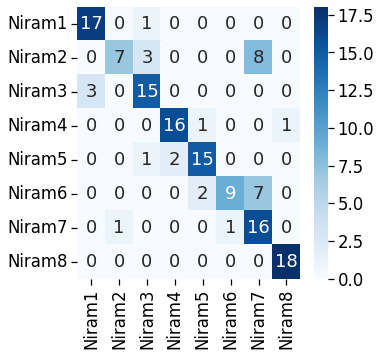

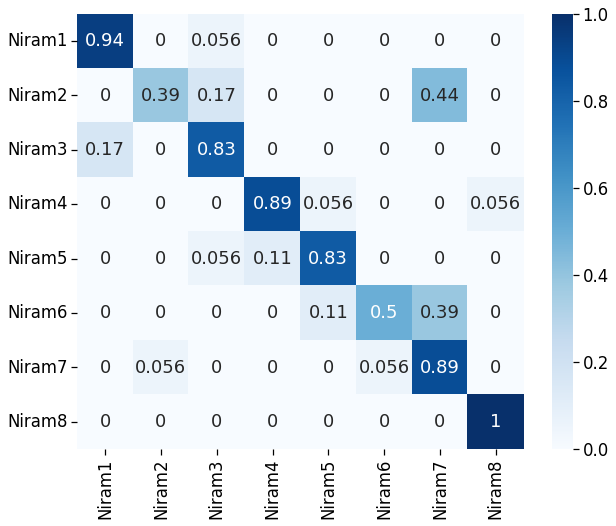

In [41]:
# make test predictions
#y_pred_test3 = trained_model.predict_proba(X_test)
y_pred_test3 = model.predict_on_batch(X_test)
y_pred_test3_classes = np.argmax(y_pred_test3, axis=1)
y_pred_test3_max_probas = np.max(y_pred_test3, axis=1)
y_test_dec=np.argmax(y_test_n, axis=1)

# confusion matrix and accuracy
conf_mat=confusion_matrix(y_test_dec, y_pred_test3_classes)
df_cm = pd.DataFrame(conf_mat, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True,cmap="Blues")
sn.set_context("notebook",font_scale=1.5)

CONF_MAT_NORM=confusion_matrix(y_test_dec, y_pred_test3_classes,normalize='true')
df_cm = pd.DataFrame(CONF_MAT_NORM, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,cmap="Blues")
sn.set_context("notebook",font_scale=1.5)
plt.savefig('sbu-lstm_mtf_cm.pdf')

In [43]:
X_train, X_test, y_train_n, y_test_n = train_test_split(X, y1, test_size=0.375, random_state=58, stratify=y1)

# Feature scaling using Standardization
  
X_train = norml_std(X_train)
X_test = norml_std(X_test)

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classification_report(y_test_n, to_categorical(classes_x)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.89      0.44      0.59        18
           2       0.71      0.83      0.77        18
           3       0.89      0.94      0.92        18
           4       0.88      0.83      0.86        18
           5       0.76      0.72      0.74        18
           6       0.54      0.72      0.62        18
           7       1.00      1.00      1.00        18

   micro avg       0.80      0.80      0.80       144
   macro avg       0.82      0.80      0.80       144
weighted avg       0.82      0.80      0.80       144
 samples avg       0.80      0.80      0.80       144



In [46]:
score22, acc22 = model.evaluate(x=X_test, y=y_test_n)
print('Test score:', score22)
print('Test accuracy:', acc22)

5/5 [==============================] - 16s 3s/step - loss: 0.3617 - binary_accuracy: 0.9479
Test score: 0.36173567175865173
Test accuracy: 0.9479166865348816


In [52]:
from keras.layers import Bidirectional

In [53]:
def create_truncated_model(trained_model):

    model32 = Sequential()
    model32.add(Bidirectional(LSTM(8,input_shape=input_shape,return_sequences=True)))
    model32.add(Bidirectional(LSTM(16,return_sequences=True)))
    model32.add(LSTM(32,return_sequences=False))
    model32.add(Dropout(0.2))


    for i, layer in enumerate(model32.layers):
        layer.set_weights(trained_model.layers[i].get_weights())

    model32.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model32

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.000s...
[t-SNE] Computed neighbors for 144 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 7.053441
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.734009
[t-SNE] KL divergence after 950 iterations: 0.140011

 
 tsne of full samples - gru - torgo


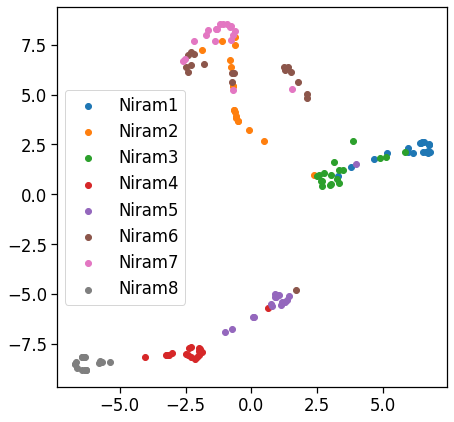

In [55]:
#truncated_model = create_truncated_model(model)
hidden_features = model.predict(X_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(hidden_features)
print('\n \n tsne of full samples - gru - torgo')
color_map = np.argmax(y_test_n, axis=1)
plt.figure(figsize=(7,7))
for cl in range(8):
    indices = np.where(color_map==cl)
    indices = indices[0]
    if cl==0:
      lab='Niram1'
    elif cl==1:
      lab='Niram2'
    elif cl==2:
      lab='Niram3'
    elif cl==3:
      lab='Niram4'
    elif cl==4:
      lab='Niram5'
    elif cl==5:
      lab='Niram6'
    elif cl==6:
      lab='Niram7'
    elif cl==7:
      lab='Niram8'
              
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=lab)
plt.legend()
plt.show()